In [ ]:
import torch
import w1d4_tests
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
fname = "./photo-1529778873920-4da4926a72c2.jpeg"
data_train, data_test =  w1d4_tests.load_image(fname)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, P, H, K):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(in_features=P, out_features=H, bias=True)
        self.linear2 = nn.Linear(in_features=H, out_features=H, bias=True)
        self.linear3 = nn.Linear(in_features=H, out_features=K, bias=True)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
w1d4_tests.test_mlp(Model)

Congrats! You've passed the test.


In [ ]:
from torch import optim

def train(model, dataloader, lr, momentum):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for input, target in dataloader:
        optimizer.zero_grad()
        output = model(input)
        loss = F.l1_loss(output, target)
        loss.backward()
        optimizer.step()
    
    return model

In [ ]:
w1d4_tests.test_train(train)

Congrats! You've passed the test.


In [ ]:
def evaluate(model, dataloader):
    total_loss = 0
    for input, target in dataloader:
        output = model(input)
        loss = F.l1_loss(output, target)
        total_loss += loss
    return total_loss / len(dataloader)

In [ ]:
w1d4_tests.test_evaluate(evaluate)

Congrats! You've passed the test.


In [ ]:
model = Model(2, 400, 3)

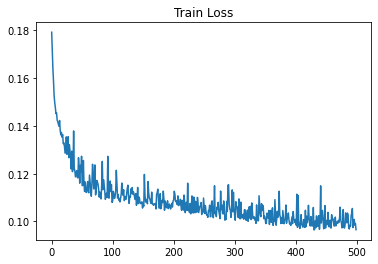

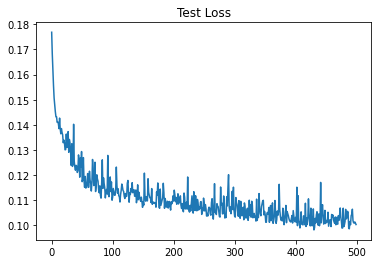

In [ ]:
n_epochs = 500
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    train(model, data_train,  lr=0.01, momentum=0.9)
    train_loss = evaluate(model, data_train)
    test_loss = evaluate(model, data_test)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
plt.plot(train_losses)
plt.title("Train Loss")
plt.show()
plt.plot(test_losses)
plt.title("Test Loss")
plt.show()

In [ ]:
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


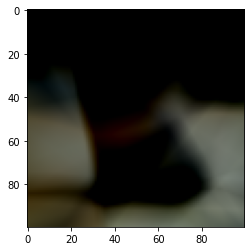

In [ ]:
resolution = 100
x = np.linspace(-0.5, 0.5, resolution)
y = np.linspace(-0.5, 0.5, resolution)

output_image = np.zeros((resolution, resolution, 3))

for i in range(resolution):
    for j in range(resolution):
        x_in = x[i]
        y_in = y[j]
        input_tensor = torch.Tensor([[x_in, y_in]])
        output_tensor = model(input_tensor)
        output_image[i,j,:] = output_tensor.detach().numpy()[0]
        
plt.imshow(output_image)

In [ ]:
def f(x, y, a=1, b=100):
    return (a-x)**2 + b*(y-x**2)**2 + 1

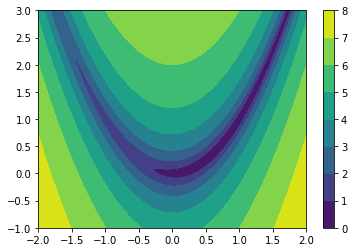

In [ ]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
xx, yy = np.meshgrid(x, y)
plt.contourf(xx, yy, np.log(f(xx, yy)))
plt.colorbar()

In [ ]:
def opt_rosenbrock(xy, lr, momentum, n_iter):
    optimizer = optim.SGD([xy], lr=lr, momentum=momentum)
    xy_values = [np.copy(xy.detach().numpy())]
    for iter in range(n_iter):
        optimizer.zero_grad()
        val = f(xy[0], xy[1])
        val.backward()
        optimizer.step()
        xy_values.append(np.copy(xy.detach().numpy()))
    return torch.Tensor(xy_values)

In [ ]:
w1d4_tests.test_rosenbrock(opt_rosenbrock)


Testing configuration:  {'lr': 0.001, 'momentum': 0.0, 'n_iter': 10}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.001, 'momentum': 0.8, 'n_iter': 20}
Congrats! You've passed the test.


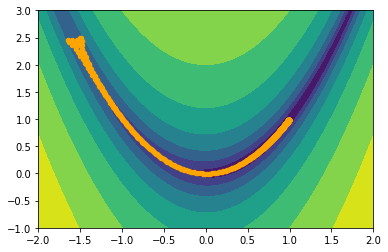

In [ ]:
xy = torch.Tensor([-1.5, 2.5])
xy.requires_grad = True
xy_traj = opt_rosenbrock(xy, 0.001, 0.9, 1000)

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
xx, yy = np.meshgrid(x, y)
plt.contourf(xx, yy, np.log(f(xx, yy)))

plt.scatter(xy_traj[:, 0], xy_traj[:, 1], s=20, c="orange")

In [ ]:
np.min(f(xx, yy))

1.0001030714254164

In [ ]:
f(xy_traj[-1][0], xy_traj[-1][1])

tensor(1.0001)

In [ ]:
class MyOptimizer():
    def __init__(self, params):
        self.params = [p for p in params]
    
    def zero_grad(self):
        for param in self.params:
            param.grad = None

In [ ]:
class MySGD(MyOptimizer):
    def __init__(self, params, lr, momentum, dampening, weight_decay):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        self.dampening = dampening
        self.weight_decay = weight_decay
        self.bt = [None]*len(self.params)
    
    def step(self):
        for i, param in enumerate(self.params):
            with torch.no_grad():
                grad = param.grad + self.weight_decay*param.data
            if self.momentum != 0:
                if self.bt[i] is None:
                    self.bt[i] = grad
                else:
                    self.bt[i] = self.momentum*self.bt[i] + (1-self.dampening)*grad
                grad = self.bt[i]
            with torch.no_grad():
                param.data -= self.lr*grad

In [ ]:
w1d4_tests.test_sgd(MySGD)


Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'dampening': 0.0, 'weight_decay': 0.05}
Congrats! You've passed the test.


In [ ]:
class MyRMSProp(MyOptimizer):
    def __init__(self, params, lr, alpha, eps, weight_decay, momentum):
        super().__init__(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.bt = [0]*len(self.params)
        self.vt = [0]*len(self.params)
    
    def step(self):
        for i, param in enumerate(self.params):
            with torch.no_grad():
                grad = param.grad + self.weight_decay*param.data
                self.vt[i] = self.alpha*self.vt[i] + (1-self.alpha)*grad**2
                vt_ = self.vt[i]
            
                if self.momentum > 0:
                    self.bt[i] = self.momentum*self.bt[i] + grad / (np.sqrt(vt_)+self.eps)
                    param.data -= self.lr*self.bt[i]
                else:
                    param.data -= self.lr*grad / (np.sqrt(vt_)+self.eps)

In [ ]:
w1d4_tests.test_rmsprop(MyRMSProp)


Testing configuration:  {'lr': 0.1, 'alpha': 0.9, 'eps': 0.001, 'weight_decay': 0.0, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.5}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.


In [ ]:
class MyAdam(MyOptimizer):
    def __init__(self, params, lr, betas, eps, weight_decay):
        super().__init__(params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.mt = [0]*len(self.params)
        self.vt = [0]*len(self.params)
        self.t = 0
    
    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            with torch.no_grad():
                grad = param.grad + self.weight_decay*param.data
                
                self.mt[i] = self.beta_1*self.mt[i] + (1-self.beta_1)*grad
                self.vt[i] = self.beta_2*self.vt[i] + (1-self.beta_2)*grad**2
                mt_hat = self.mt[i] / (1-self.beta_1**self.t)
                vt_hat = self.vt[i] / (1-self.beta_2**self.t)
                param.data -= self.lr*mt_hat / (np.sqrt(vt_hat)+self.eps)

In [ ]:
w1d4_tests.test_adam(MyAdam)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
Congrats! You've passed the test.


In [ ]:
def opt_rosenbrock_custom(optimizer, xy, lr, momentum, n_iter):
    xy_values = [np.copy(xy.detach().numpy())]
    for iter in range(n_iter):
        optimizer.zero_grad()
        val = f(xy[0], xy[1])
        val.backward()
        optimizer.step()
        xy_values.append(np.copy(xy.detach().numpy()))
    return torch.Tensor(xy_values)

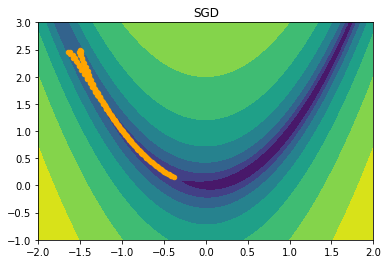

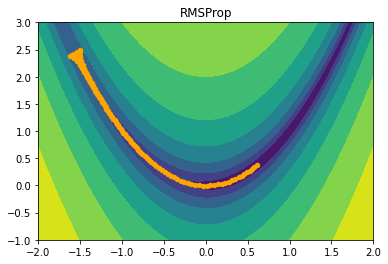

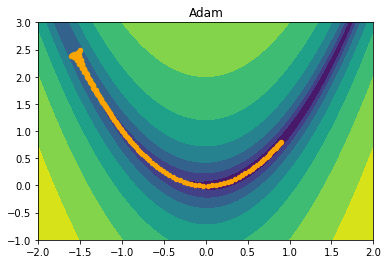

In [ ]:
optimizers = {
    "SGD": (MySGD, (0.001, 0.9, 0.1, 0.1)),
    "RMSProp": (MyRMSProp, (0.01, 0.95, 0.0001, 0.1, 0.9)),
    "Adam": (MyAdam, (0.1, (0.9, 0.95), 0.0001, 0.05))
}


for name, (opt, args) in optimizers.items():
    xy = torch.Tensor([-1.5, 2.5])
    xy.requires_grad = True
    optim = opt([xy], *args)
    xy_traj = opt_rosenbrock_custom(optim, xy, 0.001, 0.9, 150)
               
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-1, 3, 100)
    xx, yy = np.meshgrid(x, y)
    plt.contourf(xx, yy, np.log(f(xx, yy)))

    plt.scatter(xy_traj[:, 0], xy_traj[:, 1], s=20, c="orange")
    plt.title(name)
    plt.show()

In [ ]:
def train_custom(optimizer, model, dataloader, lr, momentum):
    for input, target in dataloader:
        optimizer.zero_grad()
        output = model(input)
        loss = F.l1_loss(output, target)
        loss.backward()
        optimizer.step()
    
    return model

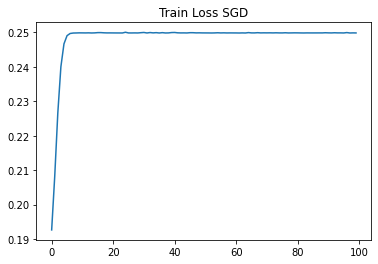

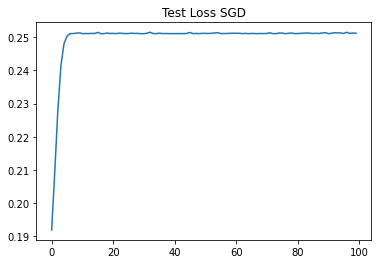

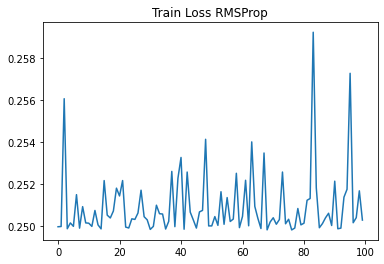

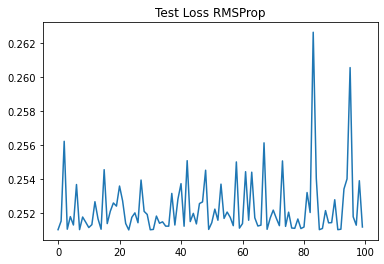

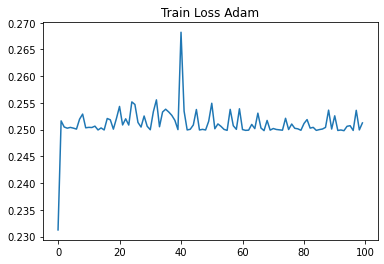

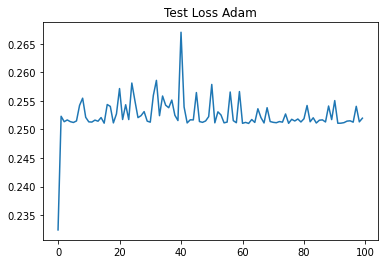

In [ ]:
optimizers = {
    "SGD": (MySGD, (0.01, 0.9, 0.1, 0.1)),
    "RMSProp": (MyRMSProp, (0.01, 0.95, 0.0001, 0.1, 0.9)),
    "Adam": (MyAdam, (0.1, (0.9, 0.95), 0.0001, 0.05))
}


for name, (opt, args) in optimizers.items():
    n_epochs = 100
    train_losses = []
    test_losses = []
    
    model = Model(2, 400, 3)
    optim = opt(model.parameters(), *args)
    
    for epoch in range(n_epochs):
        train_custom(optim, model, data_train,  lr=0.01, momentum=0.9)
        train_loss = evaluate(model, data_train)
        test_loss = evaluate(model, data_test)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    plt.plot(train_losses)
    plt.title("Train Loss " + name)
    plt.show()
    plt.plot(test_losses)
    plt.title("Test Loss " + name)
    plt.show()